In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import tensorly as tl
import scipy.signal
import scipy.stats
import sklearn
import matplotlib.pyplot as plt
import copy

import gc 

In [3]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')

%load_ext autoreload
%autoreload 2
import tensor_regression as tr
import tensor_regression.util
from tensor_regression import convolutional_fourier_tensor_regression as STR
# from tensor_regression import standard_tensor_regression as STR

%load_ext autoreload
%autoreload 2
import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers
from basic_neural_processing_modules import h5_handling
from basic_neural_processing_modules import timeSeries
from basic_neural_processing_modules import similarity
from basic_neural_processing_modules import math_functions
from basic_neural_processing_modules import misc
from basic_neural_processing_modules import decomposition
from basic_neural_processing_modules import linear_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib notebook

In [8]:
import pandas
X_all = pandas.read_csv('/media/rich/bigSSD/for_Josh/lynne_data_for_tensor_regression/lynne_for_tensor_regression_X.csv')
y_all = pandas.read_csv('/media/rich/bigSSD/for_Josh/lynne_data_for_tensor_regression/lynne_for_tensor_regression_y.csv')

In [22]:
X_all

Unnamed: 0  nTrial  nEndTrial  wi_trial_flag  cpn  cpx  lpn  lpx   ll  \
0               5     0.0        0.0          False  0.0  0.0  0.0  0.0  0.0   
1               6     0.0        0.0          False  0.0  0.0  0.0  0.0  0.0   
2               7     0.0        0.0          False  0.0  0.0  0.0  1.0  0.0   
3               8     0.0        0.0          False  0.0  0.0  0.0  0.0  0.0   
4               9     0.0        0.0          False  0.0  0.0  0.0  0.0  0.0   
...           ...     ...        ...            ...  ...  ...  ...  ...  ...   
35839       35844   233.0      232.0           True  0.0  0.0  0.0  0.0  0.0   
35840       35845   233.0      232.0           True  0.0  0.0  0.0  0.0  1.0   
35841       35846   233.0      232.0           True  0.0  0.0  0.0  0.0  0.0   
35842       35847   233.0      232.0           True  0.0  0.0  0.0  0.0  0.0   
35843       35848   233.0      232.0           True  0.0  0.0  0.0  0.0  0.0   

       rpn  rpx   rl    r   nr  
0      0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  
35839  0.0  0.0  0.0  0.0  0.0  
35840  0.0  0.0  0.0  0.0  0.0  
35841  0.0  0.0  0.0  0.0  0.0  
35842  0.0  0.0  0.0  0.0  0.0  
35843  0.0  0.0  0.0  0.0  0.0  

[35844 rows x 14 columns]

<IPython.core.display.Javascript object>


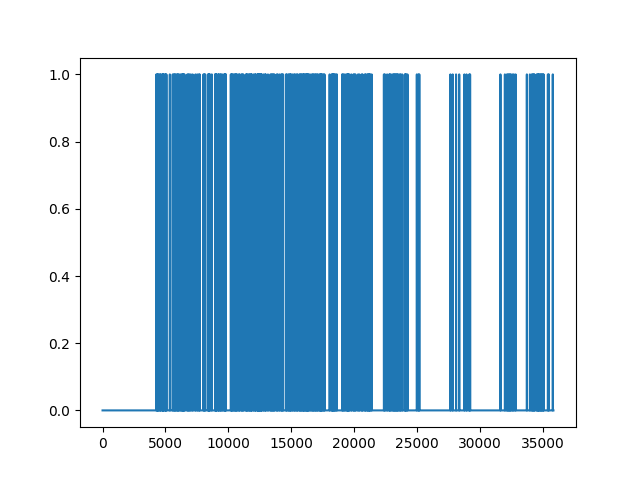

In [134]:
y_all
plt.figure()
# plt.plot(X_all.iloc[:,1])
plt.plot(np.diff(X_all.iloc[:,1]))
# plt.plot(y_all.iloc[:,1])

<IPython.core.display.Javascript object>


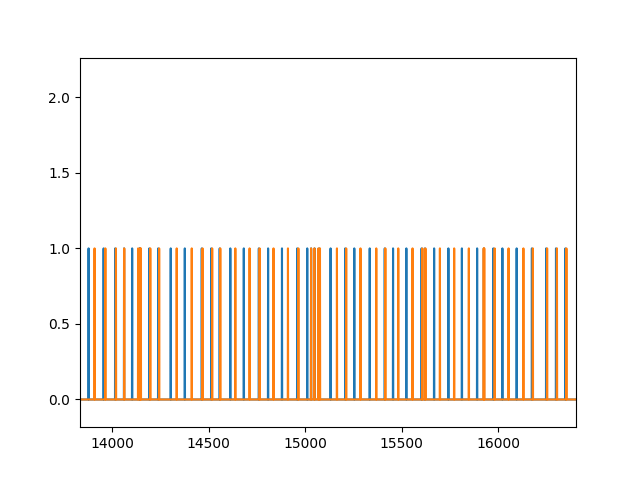

In [138]:
plt.figure()
plt.plot(X_all.iloc[:,[9,10]])

In [244]:
(X_all['wi_trial_flag']==True).sum()

12533

In [245]:
X_all.shape

(35844, 14)

In [255]:
X_all_crop.shape

(12533, 14)

In [257]:
X_all_crop = np.array(X_all[X_all['wi_trial_flag']])
y_all_crop = np.array(y_all[X_all['wi_trial_flag']])

<IPython.core.display.Javascript object>


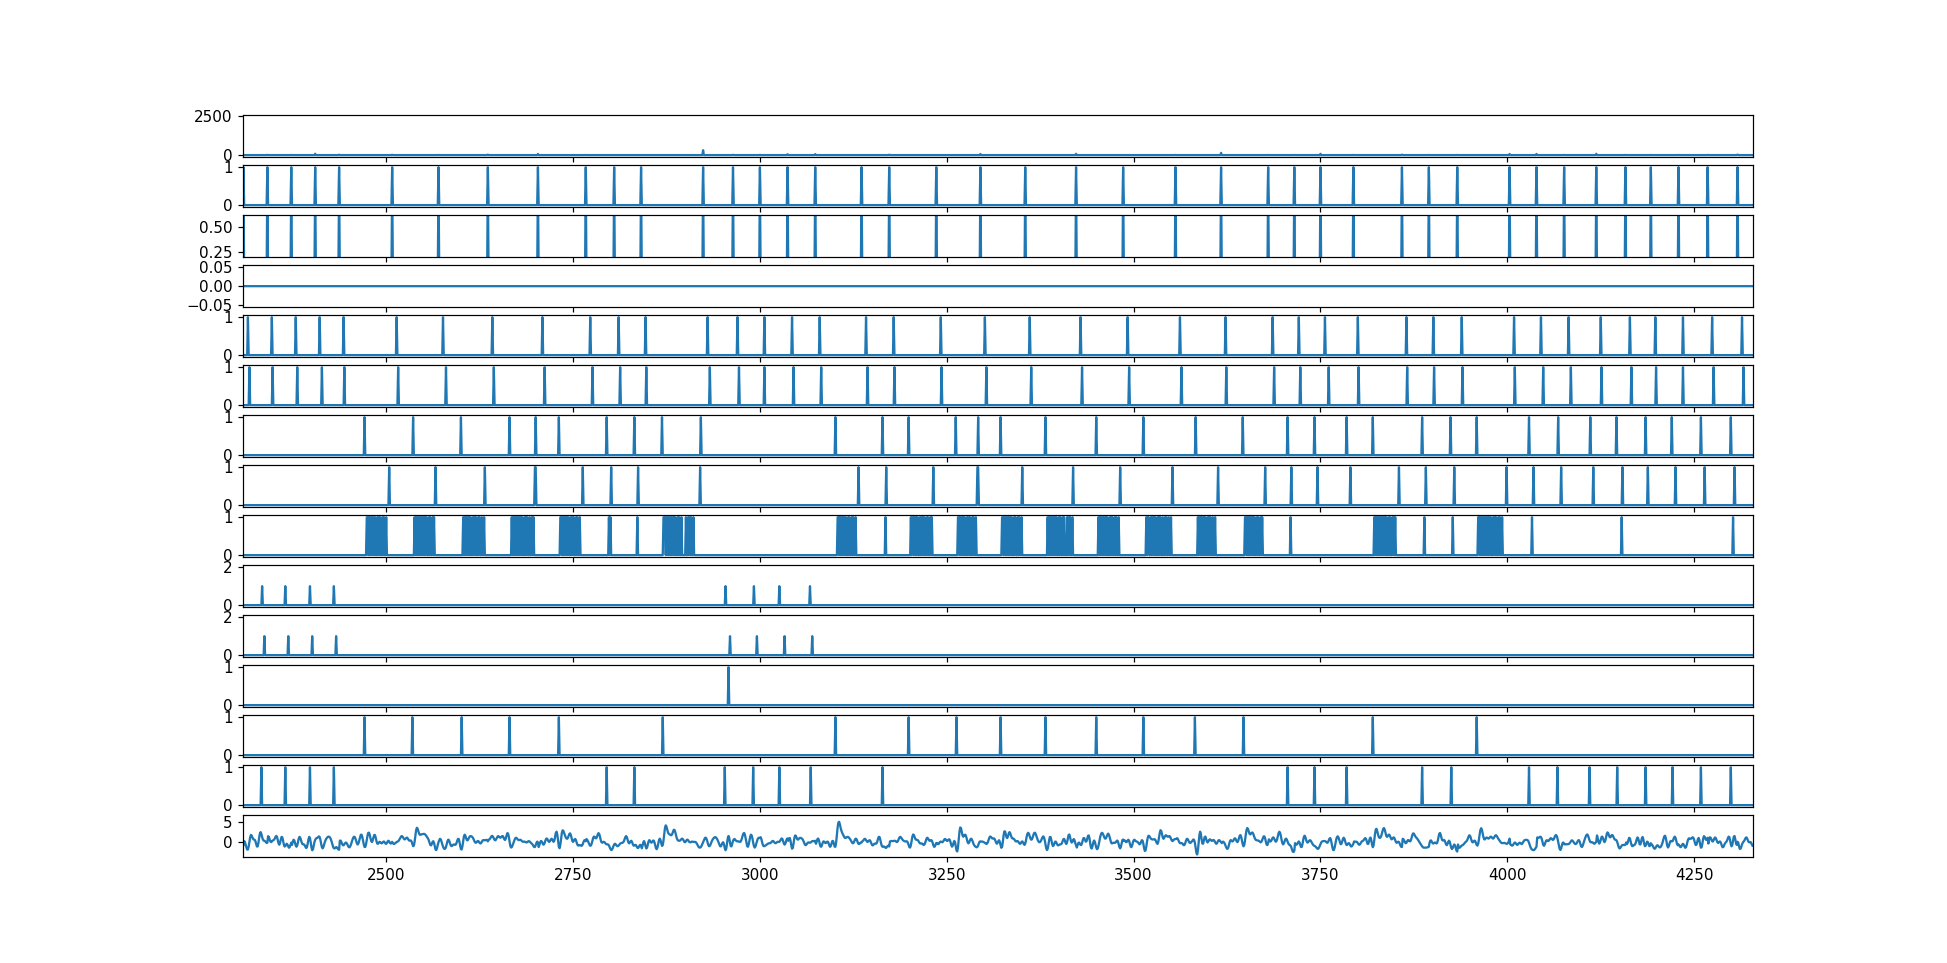

In [259]:
fig, axs = plt.subplots(X_all_crop.shape[1]+1, 1, sharex=True)
for ii in range(X_all_crop.shape[1]):
    if ii < 4:
        axs[ii].plot(np.diff(X_all_crop[:,ii]))
    else:
        axs[ii].plot(X_all_crop[:,ii])
axs[-1].plot(y_all_crop[:,1])

In [9]:
torch_helpers.show_cuda_devices()
DEVICE = tr.util.set_device(use_GPU=True, verbose=True)

1 device(s) found.
0 GeForce RTX 3090
device: 'cuda'


In [7]:
pos_array = positions['positions_convDR_meanSub_s2pInd']
print(f'pos_array.shape = {pos_array.shape}')

pos_array.shape = (432000, 2744)


In [8]:
list(neural_data)

['F_aligned', 'Fneu_aligned', 'spks_aligned']

In [9]:
ic = neural_data_info['is_cell']
good_ROIs = neural_data_info['good_ROIs']
spks = torch.tensor(neural_data['spks_aligned'][ic][good_ROIs]).T
# F = torch.tensor(neural_data['F_aligned'][ic][good_ROIs]).T
Fs = 120

<IPython.core.display.Javascript object>


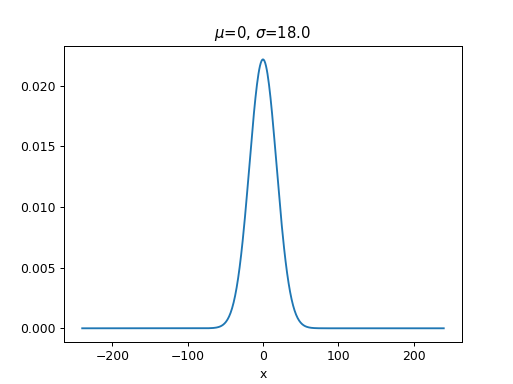

ThreadPool elapsed time : 1.22 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 1.82 seconds
neural_array.shape = (432000, 811)


In [10]:
gaussian_kernel , params_gaus = math_functions.gaussian(x=np.arange(-Fs*2,(Fs*2)+1,1),
                                                                  mu=0,
                                                                  sig=0.15*Fs,
                                                                  plot_pref=True)
spks_conv = timeSeries.convolve_along_axis(spks,
                                             gaussian_kernel,
                                             axis=0,
                                             mode='same',
                                             multicore_pref=True,
                                             verbose=True)

print(f'neural_array.shape = {spks_conv.shape}')

# win_range = [-120*3, -120*-1]
win_range = [-15, 15]

<IPython.core.display.Javascript object>


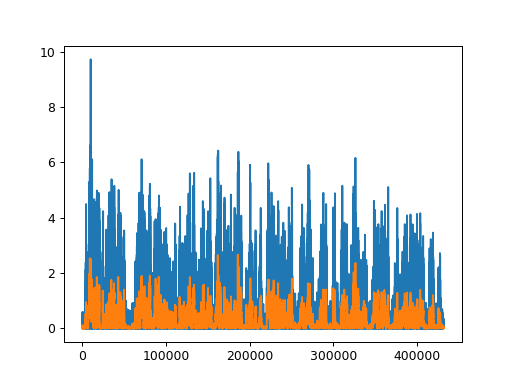

In [12]:
idx_toPlot = 35
plt.figure()
# plt.plot(dFoF[:,idx_toPlot])
plt.plot(spks[:,idx_toPlot]/40)
plt.plot(spks_conv[:,idx_toPlot]/40)

In [13]:
pos_array.shape

(432000, 2744)

In [14]:
pca_components, pca_scores, singVals, EVR = decomposition.torch_pca(pos_array, rank=pos_array.shape[1]//2, device='cuda', mean_sub=True, zscore=True, return_cpu=True, return_numpy=False)

In [14]:
pca_components_norm, pca_scores_norm, singVals, EVR = decomposition.torch_pca(pos_array / np.linalg.norm(pos_array, axis=1, keepdims=True), rank=pos_array.shape[1]//2, device='cuda', mean_sub=True, zscore=True, return_cpu=True, return_numpy=False)

torch_helpers.delete_all_cuda_tensors(globals())

In [15]:
pca_spks_components, pca_spks_scores, singVals_spks, EVR_spks = decomposition.torch_pca(spks_conv, rank=spks_conv.shape[1]//2, device='cuda', mean_sub=True, zscore=True, return_cpu=True, return_numpy=False)

torch_helpers.delete_all_cuda_tensors(globals())

<IPython.core.display.Javascript object>


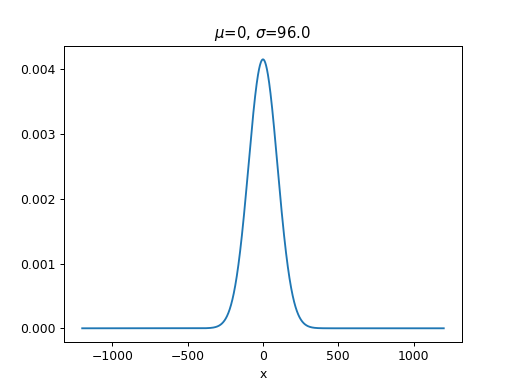

ThreadPool elapsed time : 16.45 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 17.45 seconds


In [16]:
gaussian_kernel , params_gaus = math_functions.gaussian(x=np.arange(-Fs*10,(Fs*10)+1,1),
                                                                  mu=0,
                                                                  sig=0.8*Fs,
                                                                  plot_pref=True)
pca_scores_smooth = timeSeries.convolve_along_axis(pca_scores,
                                             gaussian_kernel,
                                             axis=0,
                                             mode='valid',
                                             multicore_pref=True,
                                             verbose=True)

<IPython.core.display.Javascript object>


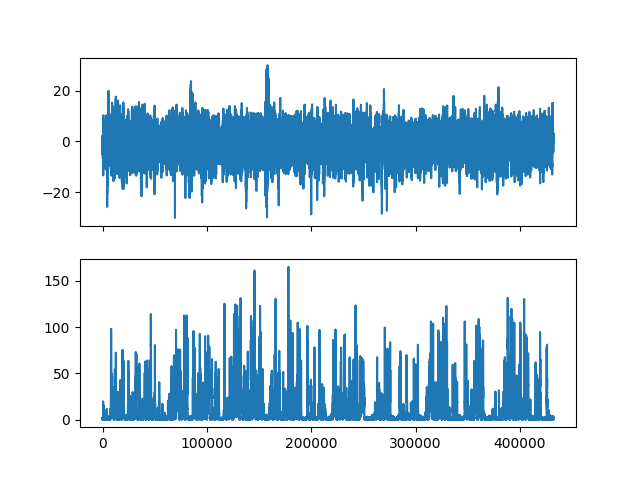

In [21]:
fig, axs = plt.subplots(2, sharex=True)
# axs[0].imshow(pca_scores[:,:10].T, aspect='auto');
axs[0].plot(pca_scores_norm[:,20]);
axs[1].plot(spks_conv[:,98])

<IPython.core.display.Javascript object>


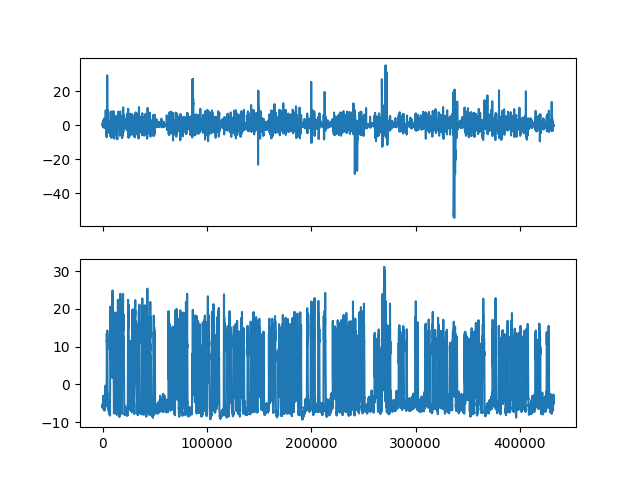

In [22]:
fig, axs = plt.subplots(2, sharex=True)
# axs[0].imshow(pca_scores[:,:10].T, aspect='auto');
axs[0].plot(pca_scores_smooth[:,20]);
axs[1].plot(pca_spks_scores_norm[:,0])

In [336]:
Fs = 20
win_len = int(5 * Fs)
# win_len = 0
# PCs_toUse = np.arange(0, 20)
# neuron_toUse = np.arange(0, 50)
# neuron_toUse = 0
# dots_toUse = np.arange(0,2744,3)
# dots_toUse = torch.randperm(2744)[:2744//2]
X_toUse = np.array([1,2,5,6,7,8,9,10,11,12,13])

time_step = 1

In [337]:
## convert X time series into a time series of time window slices

X = torch.tensor(np.array(X_all.iloc[:,X_toUse], dtype=np.float32), dtype=torch.float32)
# X = torch.tensor(np.array(X_all.iloc[:,3:], dtype=np.float32), dtype=torch.float32)
X = X / torch.max(X, dim=0)[0]
X = X - torch.mean(X, dim=0)

# # win_halfLen = [win_len//2 if win_len>1 else 0]
# n_samples = input_array.shape[0]
# slice_idx = np.arange(win_len//2, n_samples - win_len//2, time_step)
# n_slices = len(slice_idx)
# n_features = input_array.shape[1]
# # windowed_tensor = np.empty((n_slices, win_len, n_features), dtype=np.float32)
# windowed_tensor = torch.empty((n_slices, win_len, n_features), dtype=torch.float32)
# # windowed_tensor = np.empty((n_slices, 1, n_features), dtype=np.float32)
# for ii, idx in enumerate(slice_idx):
# #     ff_tensor[ii] = pos_array[idx:idx+win_len , :]
#     windowed_tensor[ii] = input_array[idx-win_len//2:(idx+(win_len-1)//2) +1 , :]
# #     windowed_tensor[ii] = input_array[idx-win_len//2:(idx+(win_len-1)//2) +1 , :] * np.hanning(win_len)[:,None]
# #     windowed_tensor[ii] = input_array[idx:idx+1 , :]

# X = windowed_tensor[:,:,:]

y = torch.tensor(y_all.iloc[:,1], dtype=torch.float32)
# y = torch.tensor(spks_conv[:,neuron_toUse], dtype=torch.float32)
y = y - torch.mean(y, dim=0)


if y.ndim==1:
    y = y[:,None]

print(f'X size: {misc.estimate_size_of_float_array(input_shape=X.shape, bitsize=32)/1000000000} GB')
print(f'X tensor shape:  {X.shape}')
print('')
print(f'y size: {misc.estimate_size_of_float_array(input_shape=y.shape, bitsize=32)/1000000000} GB')
print(f'y tensor shape:  {y.shape}')

X size: 0.001577136 GB
X tensor shape:  torch.Size([35844, 11])

y size: 0.000143376 GB
y tensor shape:  torch.Size([35844, 1])


In [338]:
del cpmlr

In [ ]:
torch_helpers.delete_all_cuda_tensors(globals())
gc.collect()
torch.cuda.empty_cache()

In [ ]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import cross_validation

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                 StratifiedKFold, GroupShuffleSplit,
                                 GroupKFold, StratifiedShuffleSplit)
Fs_X = Fs / time_step
group_len = 60*2 * Fs_X # seconds * Fs
n_splits = 1
test_size = 0.2
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
# cv = KFold(n_splits)
cv_idx_all = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)

device: 'cuda'


0it [00:00, ?it/s]

deleting cpmlr
hyperparameter val: [0. 0. 0.]


<IPython.core.display.Javascript object>


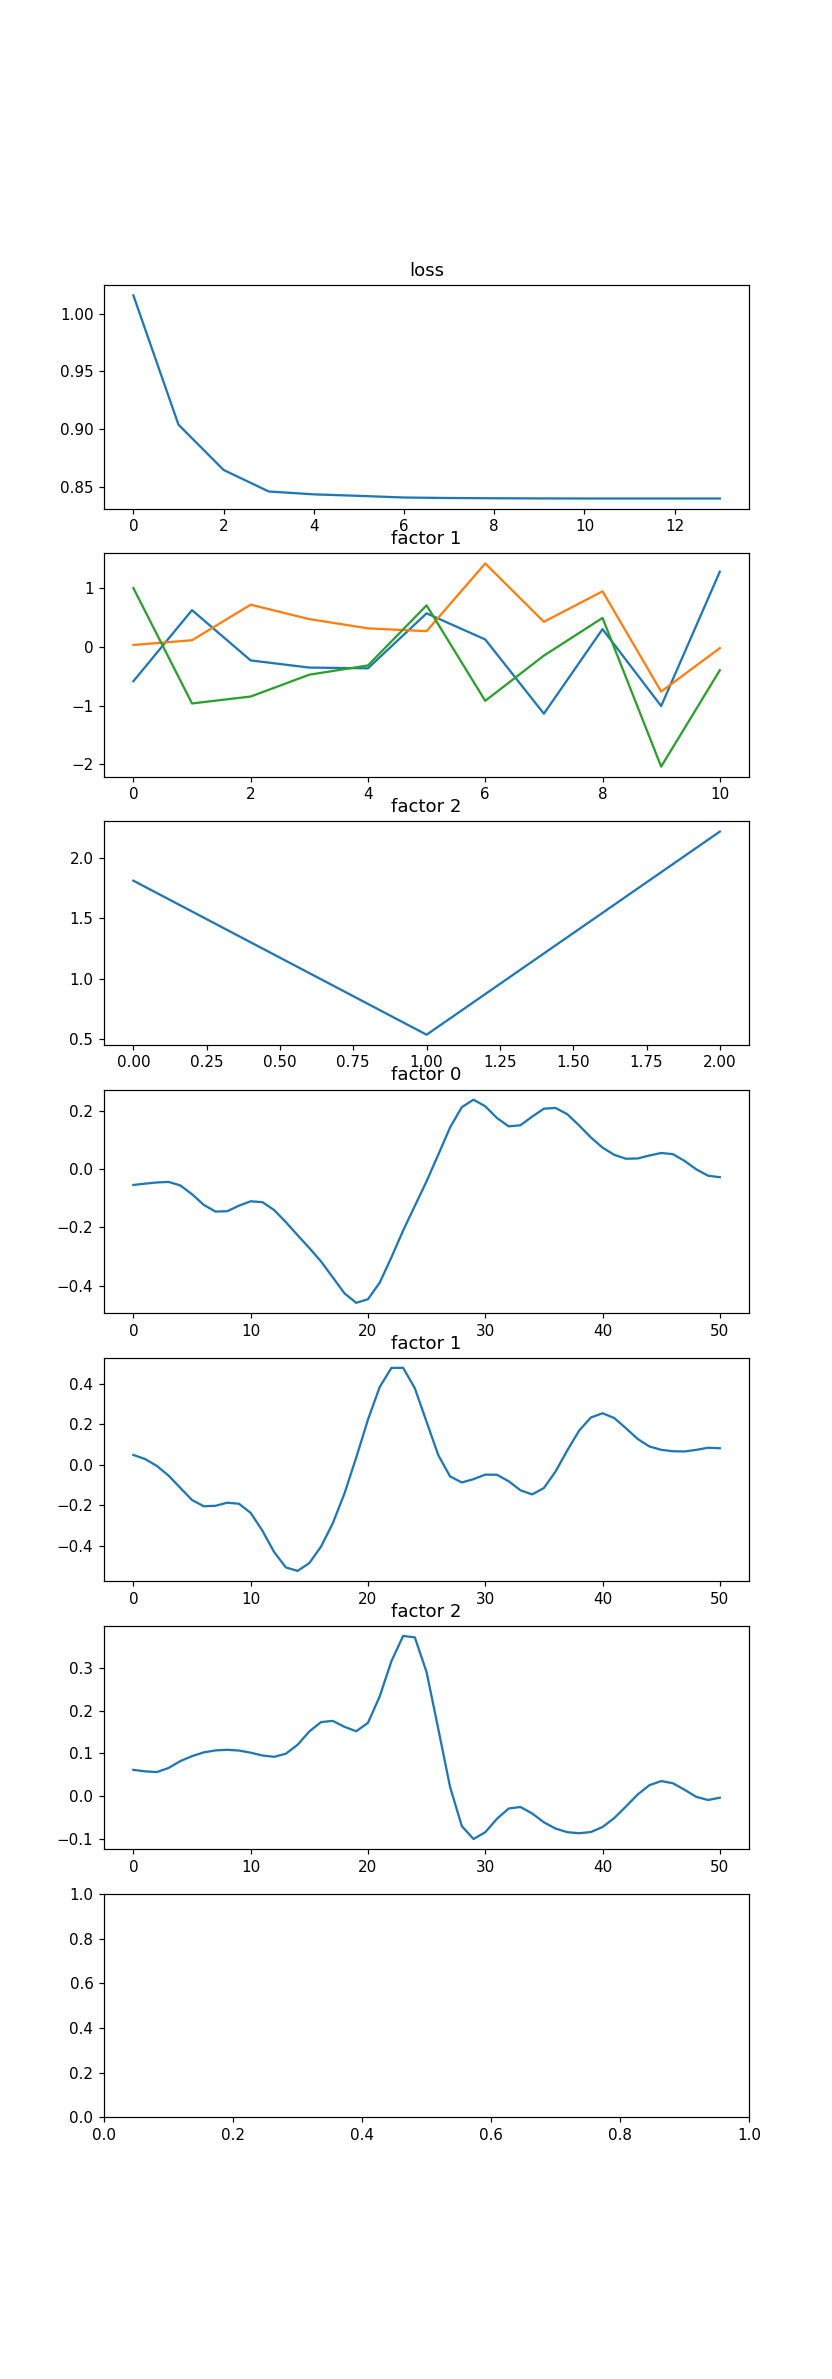

Iter: 0, loss: 1.0157, loss_rec: 0.97694, loss_L2_w: 0.0, loss_L2_n: 0.0, loss_spectral: 0.0, loss_smoothness: 0.038812, var_ratio (y_hat/y_true): 8.8322e-05
Iter: 1, loss: 0.90381, loss_rec: 0.89815, loss_L2_w: 0.0, loss_L2_n: 0.0, loss_spectral: 0.0, loss_smoothness: 0.0056598, var_ratio (y_hat/y_true): 0.06376
Iter: 2, loss: 0.8646, loss_rec: 0.86299, loss_L2_w: 0.0, loss_L2_n: 0.0, loss_spectral: 0.0, loss_smoothness: 0.0016108, var_ratio (y_hat/y_true): 0.11394
Iter: 3, loss: 0.84597, loss_rec: 0.84476, loss_L2_w: 0.0, loss_L2_n: 0.0, loss_spectral: 0.0, loss_smoothness: 0.0012043, var_ratio (y_hat/y_true): 0.13445
Iter: 4, loss: 0.84346, loss_rec: 0.84268, loss_L2_w: 0.0, loss_L2_n: 0.0, loss_spectral: 0.0, loss_smoothness: 0.00078154, var_ratio (y_hat/y_true): 0.1372
Iter: 5, loss: 0.84218, loss_rec: 0.84158, loss_L2_w: 0.0, loss_L2_n: 0.0, loss_spectral: 0.0, loss_smoothness: 0.00059952, var_ratio (y_hat/y_true): 0.13763
Iter: 6, loss: 0.84073, loss_rec: 0.8402, loss_L2_w: 0.0,

In [284]:
# %matplotlib inline
import torch
from tqdm.notebook import tqdm, trange

DEVICE = tr.util.set_device(use_GPU=True)

h_vals = [np.array([0.00, 0.00, 0.000])]


loss_all = []
params_all = []
EV_all = []
R_all = []
for ii, val in enumerate(h_vals):
    for cv_iter, cv_idx in tqdm(enumerate(cv_idx_all)):
#     for cv_iter, cv_idx in tqdm(enumerate([cv_idx_all[3]])):
        X_train = X[cv_idx[0]]
        y_train = y[cv_idx[0]]
        X_test = X[cv_idx[1]]
        y_test = y[cv_idx[1]]
        
        import gc
        if 'cpmlr' in globals():
            print('deleting cpmlr')
            del cpmlr
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()


        print(f'hyperparameter val: {val}')

        cpmlr = STR.CP_linear_regression(
                        X_shape=X_train.shape, 
                        y_shape=y_train.shape,
                        dtype=torch.float32,
                        rank_normal=3, 
                        rank_spectral=0,
                        temporal_window=win_len*1+1,
                        non_negative=[False, False, True], 
                        weights=None, 
                        Bcp_init=None, 
                        Bcp_init_scale=0.3, 
                        n_complex_dim=1, 
                        bias_init=0, 
                        device=DEVICE, 
                        do_spectralPenalty=True,
                        spectrum_smoothing_factor=100,
                        softplus_kwargs={'beta': 50,
                                         'threshold':1})

        cpmlr.fit(X_train.to(DEVICE), y_train.to(DEVICE),
            lambda_L2=  h_vals[ii], 
                        lambda_spectralPenalty=1e-5*0,
                        lambda_smooth=1e0,
                        smooth_diff_order=3,
                        max_iter=1000, 
                        tol=1e-5, 
                        patience=5,
                        verbose=3,
                        running_loss_logging_interval=1,
                        LBFGS_kwargs={
                            'lr' : 1, 
                            'max_iter' : 20, 
                            'max_eval' : None, 
                            'tolerance_grad' : 1e-07, 
                            'tolerance_change' : 1e-09, 
                            'history_size' : 100, 
                            'line_search_fn' : "strong_wolfe"
                        }
                 )

#         cpmlr.fit_Adam( X_train.to(DEVICE), y_train.to(DEVICE),
#                         lambda_L2=h_vals[ii], 
#                         lambda_spectralPenalty=5,
#                         max_iter=20000, 
#                         tol=1e-6, 
#                         patience=10000,
#                         verbose=3,
#                         plotting_interval=100,
#                     Adam_kwargs={
#                             'lr' : 0.001, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#                     )


        final_loss = cpmlr.loss_running[-1]
        print(f'loss: {final_loss}')

        y_hat_test = cpmlr.predict(X_test.cpu())
        y_hat_train = cpmlr.predict(X_train.cpu())

        y_test_aligned = y_test[cpmlr.get_idxConv(y_test.shape[0]),:]
        y_train_aligned = y_train[cpmlr.get_idxConv(y_train.shape[0]),:]

        _, EV_train, EVtw_train, EVtu_train = similarity.pairwise_orthogonalization_torch(y_train_aligned.cpu(), y_hat_train.cpu(), center=True)
        _, EV_test, EVtw_test, EVtu_test    = similarity.pairwise_orthogonalization_torch(y_test_aligned.cpu(),  y_hat_test.cpu(),  center=True)
        R_train = similarity.pairwise_similarity(y_hat_train.numpy(), y_train_aligned.numpy())
        R_test =  similarity.pairwise_similarity(y_hat_test.numpy(),  y_test_aligned.numpy())

        print(f'EV_train / EV_test: {EVtw_train} / {EVtw_test}   ;   R_train / R_test: {np.abs(R_train).mean()} / {np.abs(R_test).mean()}')

        EV_all.append([EV_train, EV_test])
        R_all.append([R_train, R_test])

In [277]:
y_hat_test = cpmlr.predict(X_test.cpu())
y_hat_train = cpmlr.predict(X_train.cpu())

y_test_aligned = y_test[cpmlr.get_idxConv(y_test.shape[0]),:]
y_train_aligned = y_train[cpmlr.get_idxConv(y_train.shape[0]),:]

_, EV_train, EVtw_train, EVtu_train = similarity.pairwise_orthogonalization_torch(y_train_aligned.cpu(), y_hat_train.cpu(), center=True)
_, EV_test, EVtw_test, EVtu_test = similarity.pairwise_orthogonalization_torch(y_test_aligned.cpu(), y_hat_test.cpu(), center=True)
R_train = similarity.pairwise_similarity(y_hat_train.numpy(), y_train_aligned.numpy())
R_test = similarity.pairwise_similarity(y_hat_test.numpy(), y_test_aligned.numpy())

print(f'EV_train / EV_test: {EVtw_train} / {EVtw_test}   ;   R_train / R_test: {np.abs(R_train).mean()} / {np.abs(R_test).mean()}')
# print(f'R = {similarity.pairwise_similarity(y_hat_test.numpy()[:,idx_toPlot].squeeze(), y_test_aligned.cpu().numpy()[:,idx_toPlot])[0][0]}')

EV_train / EV_test: 0.022167861461639404 / 0.0016370415687561035   ;   R_train / R_test: 0.14888887107372284 / 0.04046023637056351


In [186]:
y_hat_test = cpmlr.predict(X_test.cpu())
y_hat_train = cpmlr.predict(X_train.cpu())

y_test_aligned = y_test[cpmlr.get_idxConv(y_test.shape[0]),:]
y_train_aligned = y_train[cpmlr.get_idxConv(y_train.shape[0]),:]

_, EV_train, EVtw_train, EVtu_train = similarity.pairwise_orthogonalization_torch(y_train_aligned.cpu(), y_hat_train.cpu(), center=True)
_, EV_test, EVtw_test, EVtu_test = similarity.pairwise_orthogonalization_torch(y_test_aligned.cpu(), y_hat_test.cpu(), center=True)
R_train = similarity.pairwise_similarity(y_hat_train.numpy(), y_train_aligned.numpy())
R_test = similarity.pairwise_similarity(y_hat_test.numpy(), y_test_aligned.numpy())

print(f'EV_train / EV_test: {EVtw_train} / {EVtw_test}   ;   R_train / R_test: {np.abs(R_train).mean()} / {np.abs(R_test).mean()}')
# print(f'R = {similarity.pairwise_similarity(y_hat_test.numpy()[:,idx_toPlot].squeeze(), y_test_aligned.cpu().numpy()[:,idx_toPlot])[0][0]}')

EV_train / EV_test: 0.3830099403858185 / 0.37337377667427063   ;   R_train / R_test: 0.06252235174179077 / 0.09837664663791656


In [32]:
torch.log(torch.tensor(23423)**834)

tensor(nan)

In [78]:
cpmlr.Bcp_w[0].shape

torch.Size([121, 3])

<IPython.core.display.Javascript object>


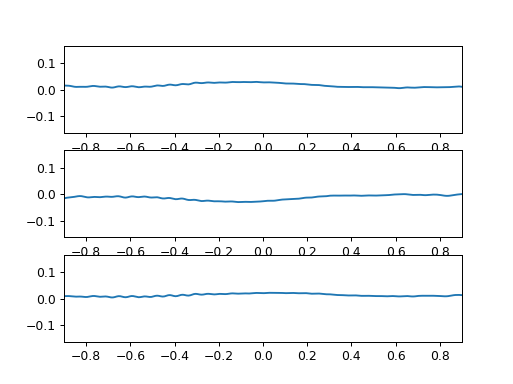

<IPython.core.display.Javascript object>


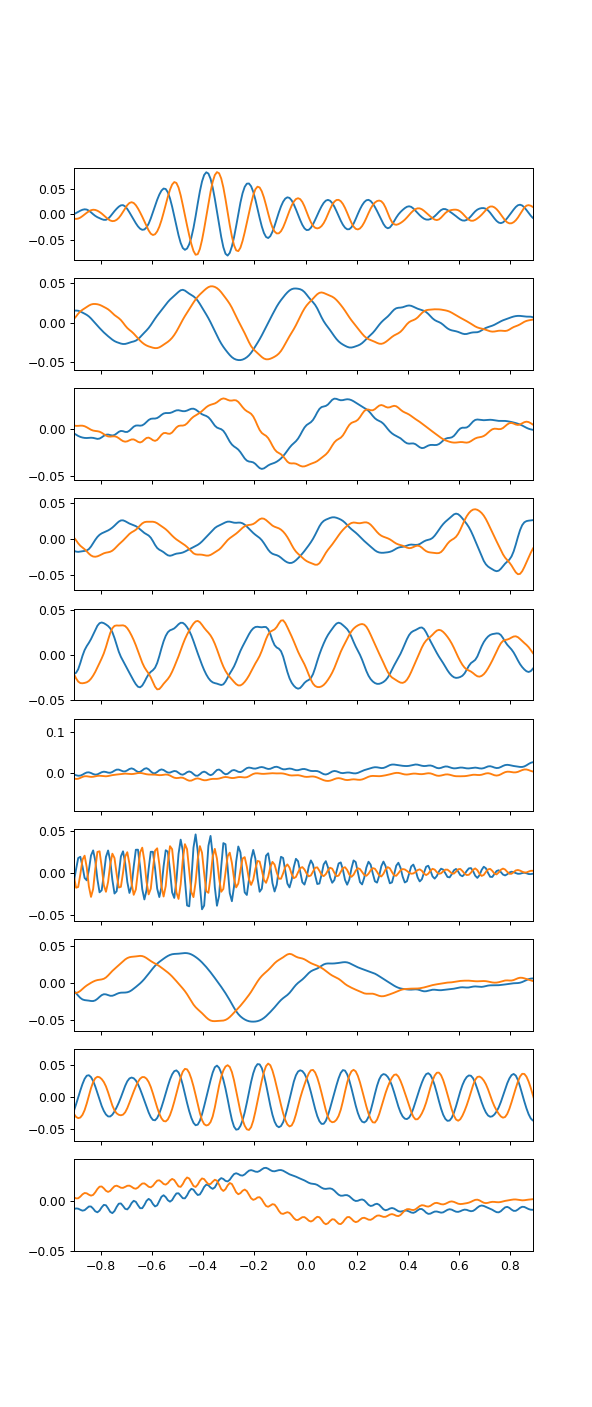

In [199]:
len_win = cpmlr.Bcp_w[0].shape[0]
xAxis =  np.arange(len_win) - len_win/2
xAxis = xAxis / Fs
fig, axs = plt.subplots(cpmlr.Bcp_w[0].shape[1], sharey=True)
for ii, ax in enumerate(axs):
    ax.plot(xAxis , cpmlr.Bcp_w[0][:,ii].squeeze().detach().cpu())
    ax.set_xlim([-0.9, 0.9])
#     ax.set_ylim([-0.05, 0.05])

fig, axs = plt.subplots(cpmlr.Bcp_w[1].shape[1], sharey=False, sharex=True)
for ii, ax in enumerate(axs):
    ax.plot(xAxis , cpmlr.Bcp_w[1][:,ii].squeeze().detach().cpu())
    ax.set_xlim([-0.9, 0.9])
#     ax.set_ylim()


In [61]:
y_hat_train.shape

torch.Size([28624, 1])

In [62]:
y_test_aligned.shape

torch.Size([7180, 1])

In [63]:
cpmlr.get_idxConv(y_test.shape[0]).shape

torch.Size([7180])

In [64]:
y_hat_test.shape

torch.Size([7180, 1])

In [288]:
# X = X[X_all['wi_trial_flag']]
# y = y[X_all['wi_trial_flag']]

X_train = X[cv_idx[0]]
y_train = y[cv_idx[0]]
X_test = X[cv_idx[1]]
y_test = y[cv_idx[1]]

In [298]:
X_all['wi_trial_flag'].iloc[cv_idx[0]]

0        False
1        False
2        False
3        False
4        False
         ...  
35839     True
35840     True
35841     True
35842     True
35843     True
Name: wi_trial_flag, Length: 28644, dtype: bool

In [326]:
X_train_cropped = np.array(X_all.loc[X_all['wi_trial_flag'].iloc[cv_idx[0]].index], dtype=np.float32)[:,X_toUse]
y_train_cropped = np.array(y_all.loc[X_all['wi_trial_flag'].iloc[cv_idx[0]].index], dtype=np.float32)[:,1][:,None]
X_test_cropped = np.array(X_all.loc[X_all['wi_trial_flag'].iloc[cv_idx[1]].index], dtype=np.float32)[:,X_toUse]
y_test_cropped = np.array(y_all.loc[X_all['wi_trial_flag'].iloc[cv_idx[1]].index], dtype=np.float32)[:,1][:,None]

In [327]:
y_test_cropped.shape

(7200, 1)

EV_test = 0.014859616756439209
R = 0.12190022319555283


<ipython-input-334-f9788f0c83b7>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, EV_test, EVtw_test, EVtu_test = similarity.pairwise_orthogonalization_torch(torch.tensor(y_test_aligned), torch.tensor(y_hat_test), center=True)


<IPython.core.display.Javascript object>


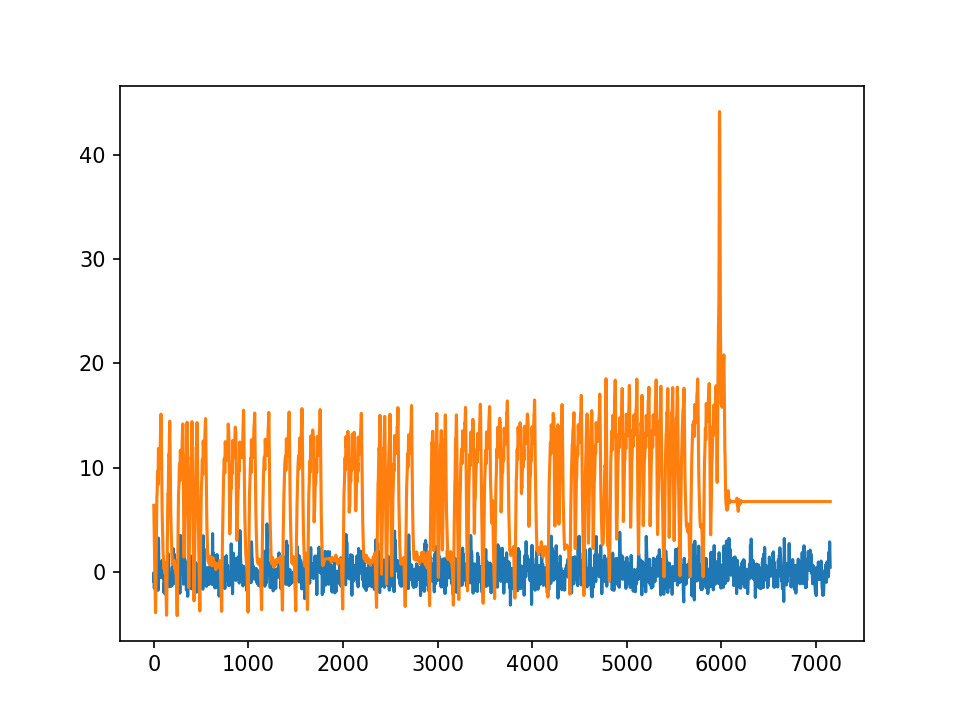

<IPython.core.display.Javascript object>


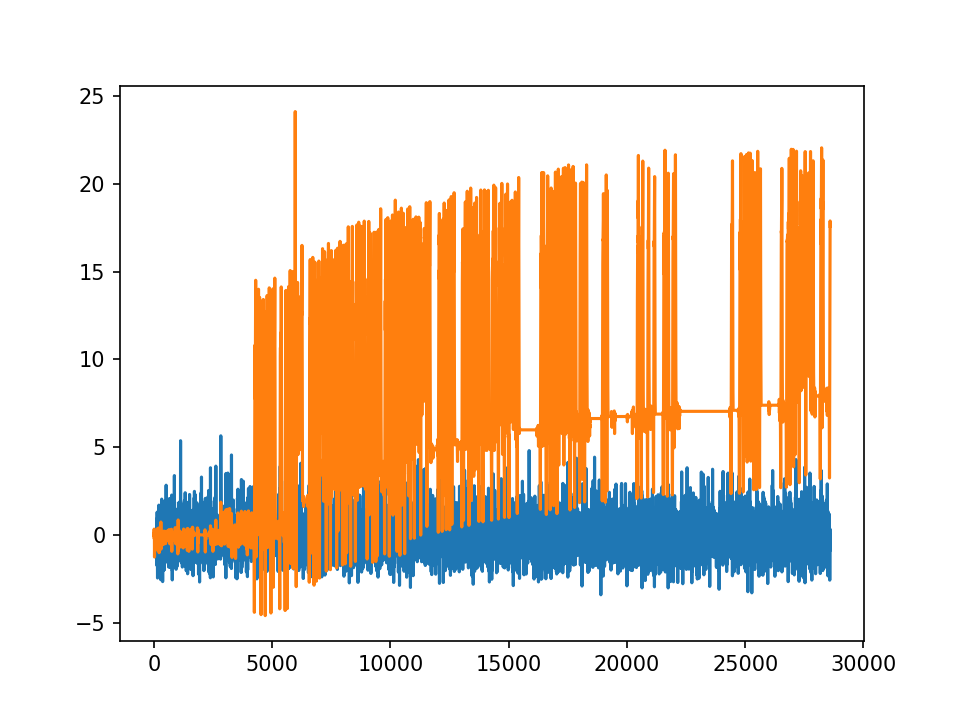

In [334]:
%matplotlib notebook

idx_toPlot = 0

y_hat_test = cpmlr.predict(X_test_cropped)
y_hat_train = cpmlr.predict(X_train_cropped)

y_test_aligned = torch.tensor(y_test_cropped[cpmlr.get_idxConv(y_test_cropped.shape[0]),:])
y_train_aligned = torch.tensor(y_train_cropped[cpmlr.get_idxConv(y_train_cropped.shape[0]),:])

_, EV_test, EVtw_test, EVtu_test = similarity.pairwise_orthogonalization_torch(torch.tensor(y_test_aligned), torch.tensor(y_hat_test), center=True)
print(f'EV_test = {EV_test[idx_toPlot]}')
print(f'R = {similarity.pairwise_similarity(y_hat_test.numpy()[:,idx_toPlot].squeeze(), y_test_aligned.cpu().numpy()[:,idx_toPlot])[0][0]}')

plt.figure()
plt.plot(y_test_aligned[:,idx_toPlot])
plt.plot(y_hat_test[:,idx_toPlot])
# plt.plot(y_hat_test2[:,idx_toPlot])
# plt.plot(pca_scores[slice_idx[cv_idx[1]],2]/30)

plt.figure()
plt.plot(y_train_aligned[:,idx_toPlot])
plt.plot(y_hat_train[:,idx_toPlot])


EV_test = 0.2008897066116333
R = 0.44820716977119446


<IPython.core.display.Javascript object>


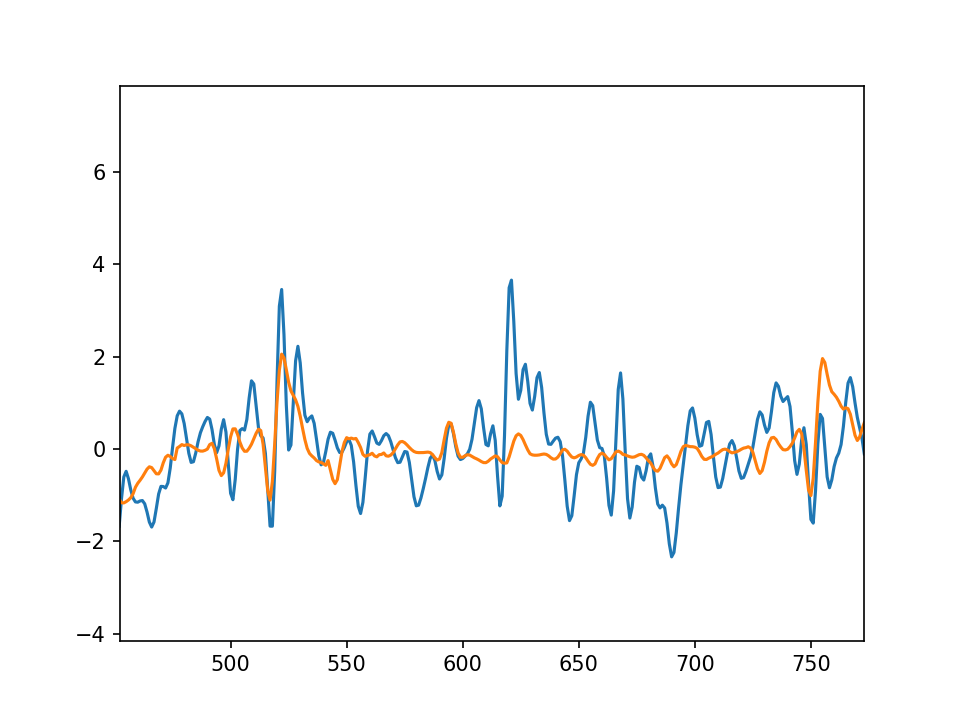

<IPython.core.display.Javascript object>


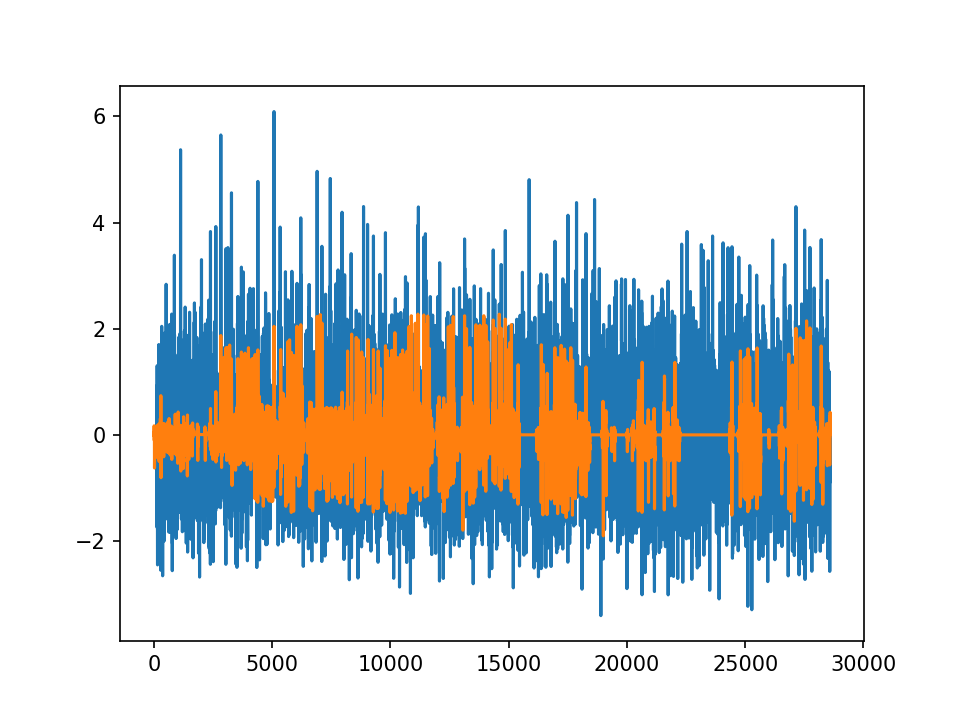

In [335]:
%matplotlib notebook

idx_toPlot = 0

y_hat_test = cpmlr.predict(X_test.cpu())
y_hat_train = cpmlr.predict(X_train.cpu())

y_test_aligned = y_test[cpmlr.get_idxConv(y_test.shape[0]),:]
y_train_aligned = y_train[cpmlr.get_idxConv(y_train.shape[0]),:]

_, EV_test, EVtw_test, EVtu_test = similarity.pairwise_orthogonalization_torch(y_test_aligned.cpu(), y_hat_test.cpu(), center=True)
print(f'EV_test = {EV_test[idx_toPlot]}')
print(f'R = {similarity.pairwise_similarity(y_hat_test.numpy()[:,idx_toPlot].squeeze(), y_test_aligned.cpu().numpy()[:,idx_toPlot])[0][0]}')

plt.figure()
plt.plot(y_test_aligned[:,idx_toPlot])
plt.plot(y_hat_test[:,idx_toPlot])
# plt.plot(y_hat_test2[:,idx_toPlot])
# plt.plot(pca_scores[slice_idx[cv_idx[1]],2]/30)

plt.figure()
plt.plot(y_train_aligned[:,idx_toPlot])
plt.plot(y_hat_train[:,idx_toPlot])


In [204]:
spks.shape

torch.Size([432000, 811])

In [212]:
print('hi') if False else None

In [205]:
torch.fft.rfft(spks, dim=0)

tensor([[ 4.8001e+06+0.0000e+00j,  8.9822e+06+0.0000e+00j,
          1.1940e+06+0.0000e+00j,  ...,
          2.4730e+05+0.0000e+00j,  7.0682e+05+0.0000e+00j,
          3.3057e+05+0.0000e+00j],
        [-3.6390e+05+2.7097e+05j,  1.1436e+05+2.4415e+05j,
         -1.6368e+05-1.1433e+05j,  ...,
          3.7658e+03+1.1867e+04j,  1.6622e+04+9.4836e+03j,
          4.9780e+03+4.9824e+03j],
        [ 3.6042e+05+2.1084e+05j,  1.8027e+05+1.3459e+06j,
          2.6962e+05+1.0003e+05j,  ...,
          1.4182e+04-6.3408e+02j,  9.3845e+03-3.1524e+04j,
         -1.2235e+03-7.4642e+03j],
        ...,
        [-1.5625e-02+0.0000e+00j, -2.6688e+01+0.0000e+00j,
         -7.8125e-03+1.5625e-02j,  ...,
         -4.3291e+00-4.8828e-04j, -1.5938e+01+9.7656e-04j,
          0.0000e+00+0.0000e+00j],
        [ 0.0000e+00+3.9062e-03j, -2.6703e+01+0.0000e+00j,
         -7.8125e-03+0.0000e+00j,  ...,
         -4.3291e+00+0.0000e+00j, -1.5938e+01+0.0000e+00j,
          2.4414e-04+4.8828e-04j],
        [ 0.0000e+00+0

In [215]:
torch.power(2,2)

AttributeError: module 'torch' has no attribute 'power'

In [216]:
np.power(2,3)

8

In [218]:
torch.sqrt([3])

TypeError: sqrt(): argument 'input' (position 1) must be Tensor, not list

<IPython.core.display.Javascript object>


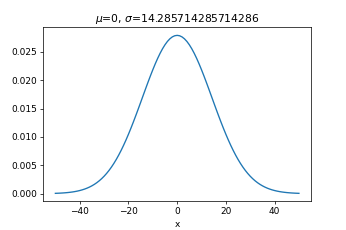

<IPython.core.display.Javascript object>


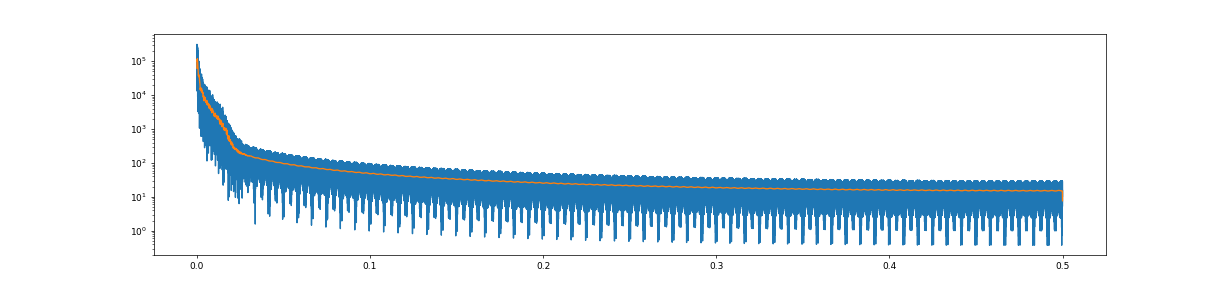

In [203]:
%matplotlib notebook

trace = y_hat_train.detach().cpu()[:,0]
pred_rfft = torch.fft.rfft(trace)
pred_freqs = torch.fft.rfftfreq(trace.shape[0])

trace = y_train.detach().cpu()[:,0][cpmlr.idx_conv.cpu()]
data_rfft = torch.fft.rfft(trace)
data_freqs = torch.fft.rfftfreq(trace.shape[0])

# data_rfft_smooth = scipy.signal.savgol_filter(torch.abs(data_rfft).numpy(), 301, 3)
# pred_rfft_smooth = scipy.signal.savgol_filter(torch.abs(pred_rfft).numpy(), 301, 3)

spectrum_smoothing_factor = 100
s = spectrum_smoothing_factor
gaus = math_functions.gaussian(np.arange(-(s//2), s//2 +1), 0, s/7, plot_pref=True)[0]
data_rfft_smooth = timeSeries.convolve_torch(torch.abs(data_rfft), torch.tensor(gaus, dtype=torch.float32), padding='same')

plt.figure()
# plt.plot(data_freqs, torch.abs(data_rfft));
# plt.plot(pred_freqs, torch.abs(pred_rfft));
# plt.plot(data_freqs, data_rfft_smooth);
# plt.plot(pred_freqs, pred_rfft_smooth);
# plt.plot(data_freqs, pred_rfft_smooth / data_rfft_smooth)
# plt.plot(data_freqs, torch.abs(pred_rfft) / torch.abs(data_rfft))

plt.plot(data_freqs, torch.abs(data_rfft))
plt.plot(data_freqs, data_rfft_smooth)
plt.yscale('log')

In [166]:
data_rfft_smooth.shape

torch.Size([172681])

# ALEX STOP HERE

In [68]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import timeSeries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


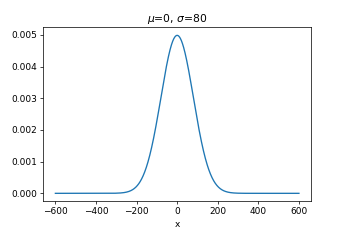

In [148]:
gaus = math_functions.gaussian(np.arange(-600,601,1), 0, 80, plot_pref=True)[0]

kern = np.vstack([np.diff(gaus, n=ii, prepend=[0]*ii) for ii in range(5)]).T
kern = kern / np.std(kern, axis=0)
# kern = np.stack([kern, kern], axis=-1)

delt = np.zeros((10000, 5,4,3))
delt[1000,0,0,0] = 1
delt[4000,0,0,0] = 1
delt[2000,1,0,0] = 1
delt[2000,2,0,0] = 1

# delt[1000,0] = 1
# delt[4000,0] = 1
# delt[2000,1] = 1
# delt[2000,2] = 1

delt[2000,0,1,0] = 1
delt[2000,0,0,1] = 1
delt[6000,1,1,1] = 1
delt[8000,0,0,2] = 1

X = torch.tensor(delt)
k = torch.tensor(kern)
c = timeSeries.convolve_torch(X,k, padding='same')

<IPython.core.display.Javascript object>


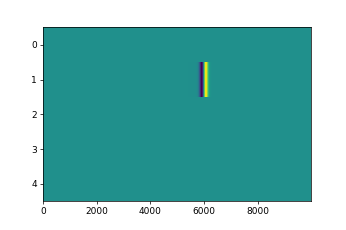

In [155]:
plt.figure()
plt.imshow(c[:,:,1,1,1].T, aspect='auto', interpolation='none')

In [133]:
delt.shape

(10000, 5)

In [134]:
kern.shape

(200, 5)

In [149]:
c.shape

torch.Size([10000, 5, 4, 3, 5])

In [ ]:
plt.plot(c)

In [128]:
path_nwb = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/data/session.nwb'

from face_rhythm.util import helpers
helpers.dump_nwb(path_nwb)

import pynwb
from pynwb import NWBHDF5IO

with pynwb.NWBHDF5IO(path_nwb, mode='r') as io:
    file = io.read()
    pts_spaced_convDR = file.processing['Face Rhythm']['Optic Flow']['pts_spaced_convDR'].data[:]

CQT
     Sxx_allPixels:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_norm:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_normFactor:    (27288, 2)   ,  float32   ,   0.000218 GB
     Sxx_xAxis:    (436601,)   ,  float64   ,   0.003493 GB
     freq_idx_toUse:    (30,)   ,  bool   ,   0.0 GB
     freqs_Sxx_all:    (30,)   ,  float64   ,   0.0 GB
     freqs_Sxx_toUse:    (30,)   ,  float64   ,   0.0 GB
Optic Flow
     color_tuples:    (309285, 3)   ,  float64   ,   0.007423 GB
     displacements:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     pointInds_toUse:    (3102, 1, 2)   ,  float32   ,   2.5e-05 GB
     positions_cleanup:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_cleanup_absolute:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_convDR_absolute:    (1372, 2, 436601)   ,  float64   ,   9.584265 GB
     positions_convDR_meanSub:    (1372, 2, 436601)   ,  float64   ,   9.584

In [129]:
def unmix_pcs(pca_components, weight_vecs):
    """
    Transforms weight_vecs into pca_components space
    RH 2021
    """
    if weight_vecs.ndim == 1:
        weight_vecs = weight_vecs[:,None]
    
    mixing_vecs = np.zeros((pca_components.shape[1], weight_vecs.shape[1]))
    mixing_vecs[:weight_vecs.shape[0],:] = weight_vecs

    return pca_components @ mixing_vecs

<IPython.core.display.Javascript object>


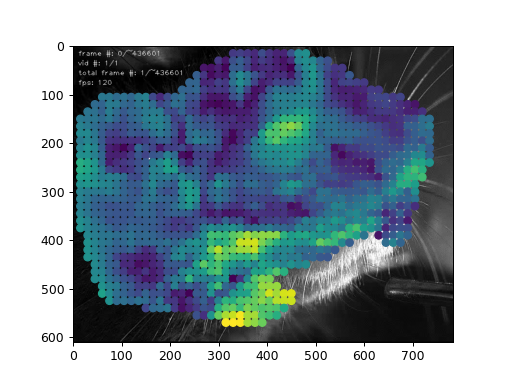

<IPython.core.display.Javascript object>


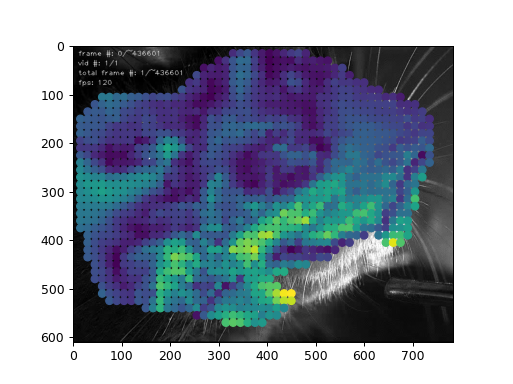

<IPython.core.display.Javascript object>


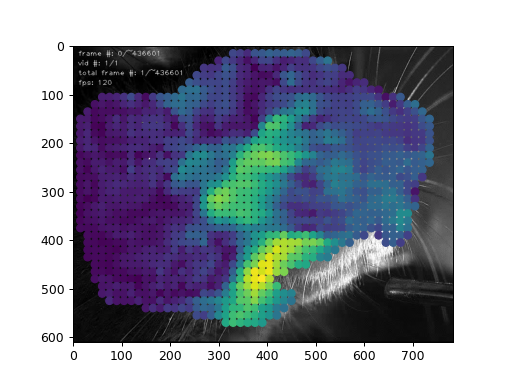

<IPython.core.display.Javascript object>


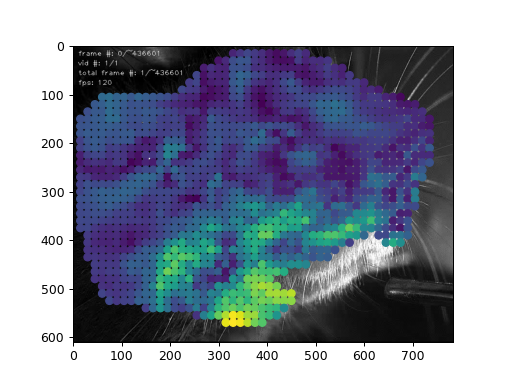

<IPython.core.display.Javascript object>


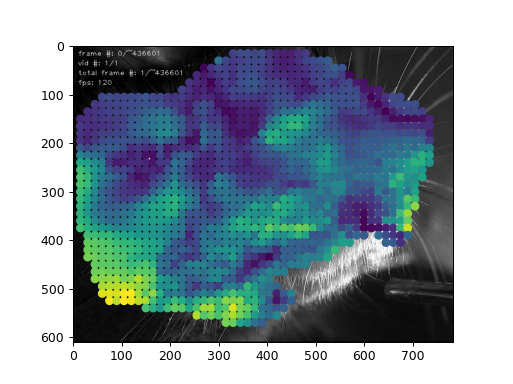

<IPython.core.display.Javascript object>


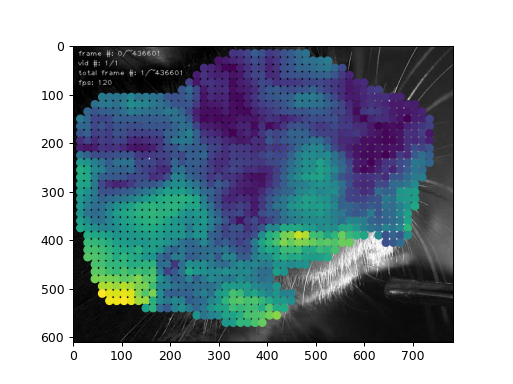

<IPython.core.display.Javascript object>


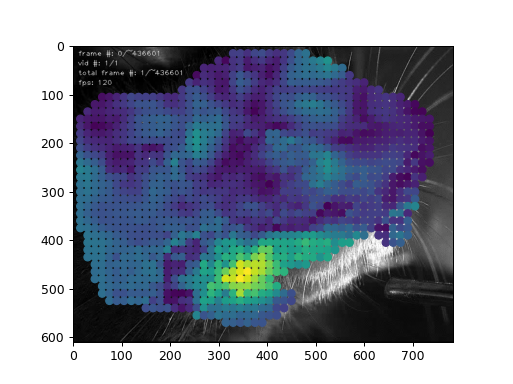

<IPython.core.display.Javascript object>


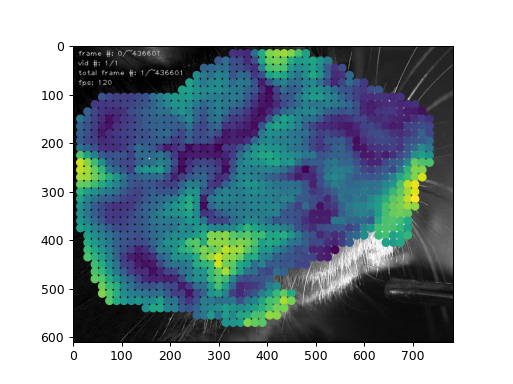

<IPython.core.display.Javascript object>


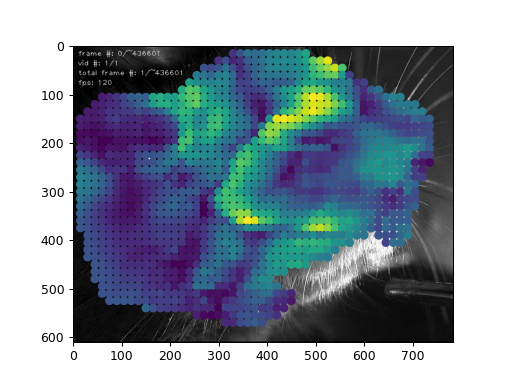

<IPython.core.display.Javascript object>


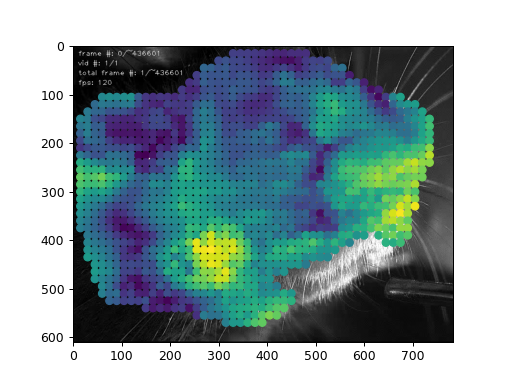

In [130]:
import imageio

# c_face_dots = cpmlr.Bcp[1].detach().cpu().numpy()
# c_face_dots = unmix_pcs(pca_components, torch.tensor([0,0,0,0,0,0,0,0,0,0,1]))
# c_face_dots = unmix_pcs(pca_components, cpmlr.Bcp[1][:,:].cpu().detach().numpy().squeeze())
# c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze()) * timeSeries.std_numba(pos_array.T)[:,None]
c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze())

# c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze())
# c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze() * np.var(pca_scores, axis=0)[:cpmlr.Bcp_n[1].shape[0], None])
# c_face_dots = unmix_pcs(pca_components, torch.sum(torch.vstack([cpmlr.Bcp_n[1][:,:,0][None,:], cpmlr.Bcp_c[1][:,:,0][None,:]]), dim=0).cpu().detach().numpy().squeeze())
c_face_dots = c_face_dots.reshape(c_face_dots.shape[0]//2, 2, c_face_dots.shape[1])
cfd_mag = np.linalg.norm(c_face_dots, axis=1)

path_mouse_movie = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/viz/just_mouse.avi'

reader = imageio.get_reader(path_mouse_movie)
for i, im in enumerate(reader):
    im_mouse = im
    break
for ii in range(cfd_mag.shape[1]):
    plt.figure()
    plt.imshow(im_mouse)
    plt.scatter(pts_spaced_convDR[:,0,0], pts_spaced_convDR[:,0,1], c=cfd_mag[:,ii]**1) # / np.mean(stds.reshape(len(stds)//2, 2), axis=1))

In [193]:
Fs = 120
PCs_toUse = np.arange(0, 300)
neuron_toUse = np.arange(0, 300)
# neuron_toUse = 35

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


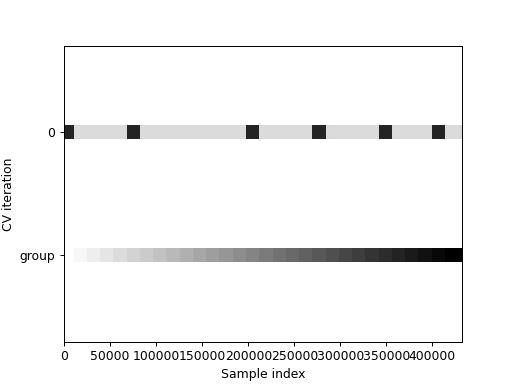

making cupy arrays
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.014
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.004 

y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.016
y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.005 

y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.094
y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.092 

y #: 3 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.028
y #: 3 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.013 

y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.075
y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.042 

y #: 5 , Roll iter: 0 , CV rep

y #: 45 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.011
y #: 45 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.158 

y #: 46 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.021
y #: 46 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.0 

y #: 47 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.136
y #: 47 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.126 

y #: 48 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.063
y #: 48 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.043 

y #: 49 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.103
y #: 49 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.042 

y #: 50 , Roll iter: 0 , CV repeat #: 0 

y #: 90 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.098
y #: 90 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.075 

y #: 91 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.005
y #: 91 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.005 

y #: 92 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.16
y #: 92 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.097 

y #: 93 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.025
y #: 93 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.009 

y #: 94 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.034
y #: 94 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.013 

y #: 95 , Roll iter: 0 , CV repeat #: 0 

y #: 135 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.213
y #: 135 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.155 

y #: 136 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.208
y #: 136 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.159 

y #: 137 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.234
y #: 137 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.17 

y #: 138 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.146
y #: 138 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.067 

y #: 139 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.072
y #: 139 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.074 

y #: 140 , Roll iter: 0 , CV re

y #: 180 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.087
y #: 180 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.06 

y #: 181 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.03
y #: 181 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.009 

y #: 182 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.043
y #: 182 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.037 

y #: 183 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.051
y #: 183 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.012 

y #: 184 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.04
y #: 184 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.008 

y #: 185 , Roll iter: 0 , CV rep

y #: 225 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.023
y #: 225 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.009 

y #: 226 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.119
y #: 226 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.101 

y #: 227 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.121
y #: 227 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.056 

y #: 228 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.017
y #: 228 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.01 

y #: 229 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.057
y #: 229 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.016 

y #: 230 , Roll iter: 0 , CV r

y #: 270 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.075
y #: 270 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.009 

y #: 271 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.01
y #: 271 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.014 

y #: 272 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.14
y #: 272 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.106 

y #: 273 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.046
y #: 273 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.037 

y #: 274 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.097
y #: 274 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.024 

y #: 275 , Roll iter: 0 , CV re

In [208]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules.linear_regression import LinearRegression_sweep
from basic_neural_processing_modules import cross_validation

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                StratifiedKFold, GroupShuffleSplit,
                                GroupKFold, StratifiedShuffleSplit)

group_len = 60*2 * Fs # seconds * Fs
n_splits = 1
test_size = 0.2
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)

# OR:

# n_splits = 1
# cv = StratifiedKFold(n_splits, shuffle=False, random_state=None, )
# cv_idx = list(cv.split(X=scores.T, y=trial_types_aligned, groups=trial_types_aligned))

X = pca_scores[:, PCs_toUse].numpy()
# X = pos_array

y = spks_conv[:, neuron_toUse]
y = y - np.mean(y, axis=0)
y = y / np.std(y, axis=0)
# y = y[:,None]


n_nonzero_rolls = 0
min_roll = 60*10*Fs
max_roll = X.shape[0] - min_roll
rolls = np.concatenate(([0] , np.random.randint(min_roll, max_roll, n_nonzero_rolls)))
n_rolls = n_nonzero_rolls + 1

model_params_cuml_ElasticNet = {
        'fit_intercept': True,
        'normalize': False,
        'max_iter': 1000,
        'tol': 0.0001,
        'selection': 'cyclic',
}
model_params_sklearn_Ridge = {
#     'alpha':1.0, 
    'fit_intercept':True, 
    'normalize':'deprecated', 
    'copy_X':True, 
    'max_iter':None, 
    'tol':0.001, 
    'solver':'auto', 
#     'positive':False, 
    'random_state':None
}
model_params_cuml_Ridge = {
    'solver': 'eig', 
    'fit_intercept': True, 
    'normalize': False, 
    'handle': None, 
    'output_type': None, 
#     'verbose': False
}

l1_ratios = np.array([0])
# alphas = np.array([0.0001, 0.01, 10, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 1000000000])
alphas = np.array([10000000])

# prepare output variables for in-place computations
n_y = y.shape[1]
n_alphas = len(alphas)
n_l1Ratios = len(l1_ratios)

theta = np.ones((n_y , n_splits , n_rolls , n_alphas , n_l1Ratios, X.shape[1]))
intercept = np.ones((n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))
EV_train  = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))
EV_test   = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))

# Run regression sweep
theta, intercept, EV_train, EV_test, preds = LinearRegression_sweep(X,
                                                                y,
                                                                cv_idx,
                                                                alphas=alphas,
                                                                l1_ratios=l1_ratios,
                                                                rolls=rolls,
                                                                method_package='cuml',
                                                                method_model='Ridge',
                                                                compute_preds=True,
                                                                verbose=2,
                                                                theta_inPlace=theta, 
                                                                intercept_inPlace=intercept,
                                                                EV_train_inPlace=EV_train,
                                                                EV_test_inPlace=EV_test,
                                                                **model_params_cuml_Ridge
                                                                )

In [214]:
EV = np.empty((theta.shape[0], theta.shape[3]))
for iter_y in range(theta.shape[0]):
# for iter_y in range(3):
    for iter_alpha in range(theta.shape[3]):
        y_pred_tmp = theta[iter_y,:,:,iter_alpha,:,:].squeeze() @ X[cv_idx[0][1],:].T
        EV[iter_y, iter_alpha] = similarity.pairwise_orthogonalization(y[cv_idx[0][1], iter_y][:,None], y_pred_tmp[:,None])[1]

<IPython.core.display.Javascript object>


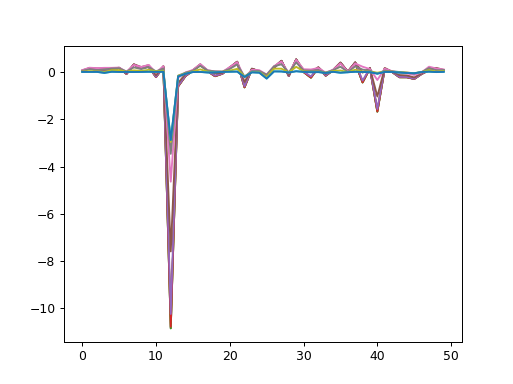

In [233]:
plt.figure()
plt.plot(EV_test.squeeze())

<IPython.core.display.Javascript object>


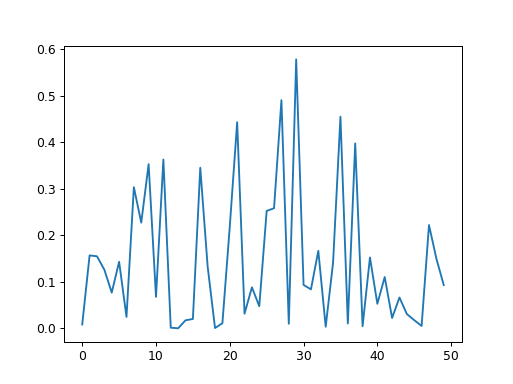

In [254]:
plt.figure()
plt.plot(EV.squeeze())

In [38]:
EV.mean(0)

array([0.36192392])

In [203]:
similarity.pairwise_orthogonalization(y[cv_idx[0][1], iter_y][:,None], y_pred_tmp[:,None])

(array([[-0.16668497, -0.23569377, -0.24289354, ..., -0.47835029,
         -0.44270835, -0.41476091]]),
 array([0.05994709]),
 0.05994708726786768,
 0.05994708726786768)

In [193]:
X[cv_idx[0][1]].T.shape

(200, 86400)

In [194]:
theta[iter_y,:,:,iter_alpha,:,:].squeeze().shape

(200,)

In [172]:
similarity.pairwise_orthogonalization(y[cv_idx[0][1]], preds.squeeze()[:,ii,:].T)

AssertionError: 

In [173]:
preds.squeeze()[:,ii,:].shape

(50, 432000)

In [176]:
y[cv_idx[0][1]].shape

(86400, 50)

In [88]:
np.maximum(0,EV_test.squeeze()).mean(0)

array([0.08266119, 0.08266143, 0.08268448, 0.08288539, 0.08418981,
       0.0812776 ])

In [95]:
np.maximum(0,EV_test.squeeze()).mean(0)

0.08451055126554169

In [100]:
np.maximum(0,EV_test.squeeze()).mean(0)

0.0702680324482953

In [125]:
np.maximum(0,EV_test.squeeze()).mean(0)

0.11739642839470169

In [124]:
np.maximum(0,EV_train.squeeze()).mean(0)

0.23401128399402846

<IPython.core.display.Javascript object>


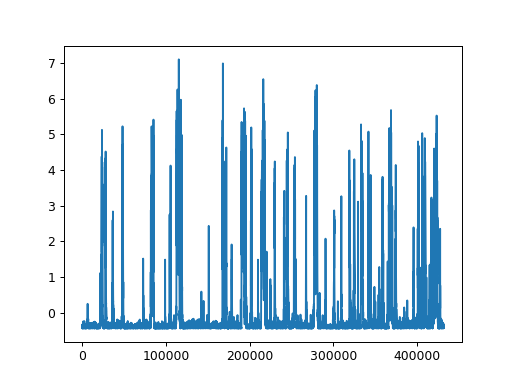

In [153]:
plt.figure()
plt.plot(y[:,0])

<IPython.core.display.Javascript object>


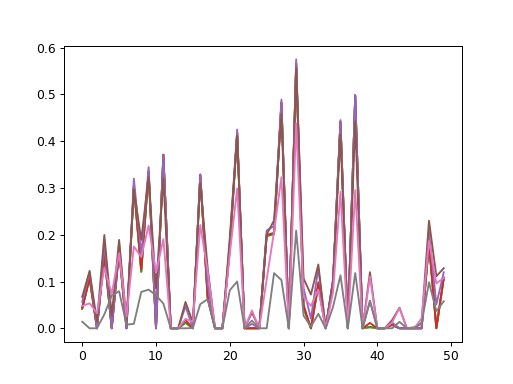

In [164]:
plt.figure()
plt.plot(np.maximum(0,EV_test.squeeze()))

In [178]:
X.shape

torch.Size([144000, 1, 300])

In [181]:
pca_scores.shape

torch.Size([432000, 1372])

In [179]:
pos_array.shape

(432000, 2744)

In [180]:
spks_conv.shape

(432000, 811)

In [25]:
{
    'alpha':1.0, 'fit_intercept':True, 'normalize':'deprecated', 'copy_X':True, 'max_iter':None, 'tol':0.001, 'solver':'auto', 'positive':False, 'random_state':None
}


{'alpha': 1.0,
 'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'auto',
 'positive': False,
 'random_state': None}